In [1]:
# libraries required for model
# pip install librosa soundfile numpy sklearn pyaudio

In [2]:
# these are the required modules 
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [3]:
# we need to use three features of a sound file, which are mfcc:Mel Frequency Cepsral Coefficient
# which represents the short-term power spectrum of a sound 
# about mfccc:wikipedia link - https://en.wikipedia.org/wiki/Mel-frequency_cepstrum 
# 2nd feature is chroma: pertains to 12 different pitch classes
# 3rd feature is mel: Mel spectrogram Frequency

def features_extraction_from_soundfile(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [4]:
# now we will create a dictionary to hold numbers and emotions that are present in ravdess dataset
feelings={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

# these are the emotions which is used to detect stress
observed_feelings=['happy','neutral','sad', 'angry', 'fearful']

In [5]:
# now we should load the ravdess data and the number in the feelings dictionary and the data files 
# contain the number with dashed in between eg: 01-02-01-07.wvl
# import os,glob,pickle
def load_data_from_dataset(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("E:\\vjhackaton\\VJH_012\\dataset\\Actor_*\\*.wav"):
        file_name=os.path.basename(file)
        feeling=feelings[file_name.split("-")[2]]
        if feeling not in observed_feelings:
            continue
        feature=features_extraction_from_soundfile(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(feeling)
    
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [6]:
# splitting the dataset into train and test 
x_train,x_test,y_train,y_test=load_data_from_dataset(test_size=0.25)

In [7]:
# shape of the training and testing dataset
print((x_train.shape[0], x_test.shape[0]))

(621, 207)


Text(0.5, 1.0, 'Waveplot - Male Neutral')

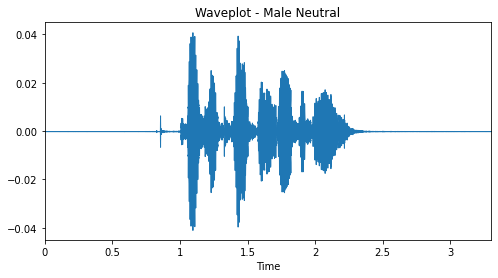

In [8]:
# plotting waveplot
import matplotlib.pyplot as plt
import librosa.display
%matplotlib inline
plt.figure(figsize=(8, 4))
x,sr1 = librosa.load("E:\\vjhackaton\\VJH_012\\dataset\\Actor_01\\03-01-01-01-01-01-01.wav")
librosa.display.waveplot(x,sr=sr1)
plt.title('Waveplot - Male Neutral')


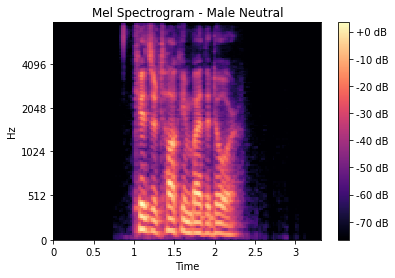

In [9]:
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr1, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Neutral')
# plt.savefig('MelSpec_MaleNeutral.png')
plt.colorbar(format='%+2.0f dB');

In [10]:
# features
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [11]:
# Now we are going to create a model ,
# the algorithm we used to build is MLPClassifier(Multi Layer Perceptron Classifier)
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [12]:
# fitting the model 
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [13]:
# getting the predicted values
y_pred=model.predict(x_test)

In [14]:
# getting accuracy_score
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy score: {:.2f}%".format(accuracy*100))

Accuracy score: 62.80%


In [15]:
with open('model_pickle','wb') as file:
    pickle.dump(model,file)
with open('model_pickle','rb') as file:
    mp = pickle.load(file)
    
# mp.predict([[5000]])

In [16]:
import joblib
joblib.dump(model, 'model')
mj = joblib.load('model')

In [17]:
x_testing = x_test[0]
mp.predict([x_testing])

array(['angry'], dtype='<U7')

In [18]:
x = "E:\\vjhackaton\\VJH_012\\dataset\\testing\\03-01-03-02-01-01-24.wav"
x_testing2 = features_extraction_from_soundfile(x,mfcc=True,chroma=True,mel=True)
mp.predict([x_testing2])

array(['happy'], dtype='<U7')

In [20]:
print(x_train[1],y_train[1])

[-4.83325623e+02  4.22921944e+01 -7.69092417e+00  1.68036346e+01
  3.23886776e+00 -4.13074398e+00 -1.93029058e+00 -4.23250818e+00
 -1.96569884e+00  2.02020526e+00  1.60848665e+00  1.97999179e+00
  4.36226372e-03  3.62556338e+00 -2.93347192e+00 -2.59113002e+00
  1.46224344e+00  2.95814890e-02 -2.63227129e+00 -4.94483203e-01
 -2.67357969e+00 -1.23616004e+00 -8.19524109e-01  1.19425133e-01
 -1.63785052e+00 -7.45011330e-01 -6.29319966e-01  3.81209087e+00
  2.98446488e+00  5.20075321e+00  3.65318966e+00  4.90893364e+00
  3.04706669e+00  3.65389800e+00  3.05631781e+00  2.69851327e+00
  9.61750329e-01  2.79772043e+00  2.80649996e+00  3.17152929e+00
  6.27624393e-01  7.25388765e-01  7.01661646e-01  7.47256994e-01
  7.66767681e-01  7.66769111e-01  7.37534940e-01  7.65109420e-01
  7.69162774e-01  7.76875675e-01  7.64928639e-01  6.79624856e-01
  1.87766291e-02  2.59803375e-03  1.22612529e-03  5.34553407e-03
  2.23920103e-02  2.73481101e-01  1.25228858e+00  1.21362686e+00
  1.59841204e+00  3.87070

In [21]:
print(x_testing2)

[-5.15854431e+02  2.35887413e+01 -2.07358341e+01  5.94987631e+00
 -2.03964787e+01 -9.24988651e+00 -1.17979631e+01 -8.41280460e+00
 -3.36521506e+00 -8.76996517e+00  2.50473070e+00 -7.99495649e+00
 -5.78071237e-01 -1.60435224e+00 -8.50483799e+00  2.72751957e-01
 -6.23784256e+00  5.92952967e-01 -3.87271613e-01  8.75582695e-01
  3.66258907e+00  4.95695353e+00  4.62903357e+00  2.23004866e+00
  3.34340185e-01  3.98490858e+00  3.71867299e+00  9.91162300e+00
  5.24005985e+00  2.14117837e+00 -1.48463714e+00  1.98442745e+00
  4.45191056e-01  2.16963924e-02 -3.55134892e+00 -7.90532529e-01
 -2.40508825e-01  5.80796003e-01 -1.63725758e+00 -2.61674333e+00
  5.60326815e-01  6.21002376e-01  5.91118693e-01  5.50850213e-01
  5.32920778e-01  6.03641629e-01  5.54554403e-01  5.30105591e-01
  6.08929098e-01  6.09773278e-01  6.18602693e-01  5.78081071e-01
  4.88010672e-04  1.75929585e-04  1.09068686e-04  6.82257669e-05
  5.15780084e-05  7.80867122e-05  8.07426695e-05  2.70327902e-03
  4.65488657e-02  1.12585